# Sonoma Animal Shelter: EDA and outcome prediction

### Importing the necessary libraries and data

In [74]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [2]:
data = pd.read_csv('Data/Animal_Shelter_Intake_and_Outcome.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22530 entries, 0 to 22529
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  16732 non-null  object 
 1   Type                  22530 non-null  object 
 2   Breed                 22530 non-null  object 
 3   Color                 22530 non-null  object 
 4   Sex                   22530 non-null  object 
 5   Size                  22498 non-null  object 
 6   Date Of Birth         16981 non-null  object 
 7   Impound Number        22530 non-null  object 
 8   Kennel Number         22513 non-null  object 
 9   Animal ID             22530 non-null  object 
 10  Intake Date           22530 non-null  object 
 11  Outcome Date          22407 non-null  object 
 12  Days in Shelter       22530 non-null  int64  
 13  Intake Type           22530 non-null  object 
 14  Intake Subtype        22530 non-null  object 
 15  Outcome Type       

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,REMY,DOG,BEAGLE,BLACK/WHITE,Female,MED,04/11/2014,K21-039564,DS69,A406645,...,PHONE,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407.0,"95407(38.403734, -122.736775)",1
1,*RONDE,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,07/24/2020,K21-039133,DA30,A406003,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,94954.0,"94954(38.245316, -122.59871)",1
2,*SNOOP,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,08/04/2019,K21-039232,CA02,A406151,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1
3,FIFI,CAT,SIAMESE,SEAL PT,Spayed,KITTN,10/27/2020,K21-037796,CA03,A402286,...,OVER THE COUNTER,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407.0,"95407(38.403734, -122.736775)",1
4,*COUSIN IT,OTHER,ANGORA-SATIN,TAN/BLACK,Neutered,SMALL,11/29/2019,K21-039617,CA01,A406718,...,OVER THE COUNTER,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,NaN,95482.0,"95482(39.150868, -123.215335)",1


Most variables in the dataset are of type object, that is, they are categorical.
Both Intake Date and Outcome Date are of the object type. We have to convert it to DateTime type during data cleaning.

## 1. Data Cleaning and Feature Engineering

Perform a check to see how many values are missing in the dataset.

In [3]:
data.isnull().sum()

Name                    5798
Type                       0
Breed                      0
Color                      0
Sex                        0
Size                      32
Date Of Birth           5549
Impound Number             0
Kennel Number             17
Animal ID                  0
Intake Date                0
Outcome Date             123
Days in Shelter            0
Intake Type                0
Intake Subtype             0
Outcome Type             129
Outcome Subtype          430
Intake Condition           0
Outcome Condition        459
Intake Jurisdiction        0
Outcome Jurisdiction    3130
Outcome Zip Code        3199
Location                3199
Count                      0
dtype: int64

Some entries are missing values for Outcome Type that our models will be predicting (target variable). Presumably the reason is that the outcome has not occurred yet (the animal is still in a shelter). Given that there are only 129 such instances and the reasons for their absence are not entirely clear, we decided to remove them from the dataset. We also discarded 32 instances with no size value. We select only the features we need from the dataset, which allows us to deal with most of the missing values, we leave the rest because of their significance and high quantities.

In [4]:
# Drop the entries missing Outcome Type and Size values
data = data[~data['Outcome Type'].isnull()]
data = data[~data['Size'].isnull()]

# Remove the redundant and outcome related features that won't be used for predicting the outcome type
data_sel = data.drop(
    ['Animal ID', 'Kennel Number', 'Impound Number', 'Outcome Subtype', 'Outcome Jurisdiction', 'Outcome Condition',
     'Outcome Zip Code', 'Count'], axis=1)
data_sel.isnull().sum()

Name                   5759
Type                      0
Breed                     0
Color                     0
Sex                       0
Size                      0
Date Of Birth          5494
Intake Date               0
Outcome Date              0
Days in Shelter           0
Intake Type               0
Intake Subtype            0
Outcome Type              0
Intake Condition          0
Intake Jurisdiction       0
Location               3090
dtype: int64

The age of the animal can be an important feature in predicting the outcome type, so we create 2 additional features that indicate the age of an animal (in both months and years) at intake. For instances that are missing these values, we fill in 999 for their age.

In [5]:
# Convert variables to datetime format
data_sel['Date Of Birth'] = pd.to_datetime(data_sel['Date Of Birth'])
data_sel['Intake Date'] = pd.to_datetime(data_sel['Intake Date'])
# Compute the age in months at intake
data_sel['Age (months) at Intake'] = ((data_sel['Intake Date'] - data_sel['Date Of Birth']) / np.timedelta64(1, 'M'))
data_sel['Age (years) at Intake'] = ((data_sel['Intake Date'] - data_sel['Date Of Birth']) / np.timedelta64(1, 'Y'))
# Fill NaN values with 999 years (?)
data_sel['Age (months) at Intake'] = data_sel['Age (months) at Intake'].fillna(999).astype(int)
data_sel['Age (years) at Intake'] = data_sel['Age (years) at Intake'].fillna(999).astype(int)
#data_sel = data_sel.drop(['Outcome Date'], axis=1)
data_sel.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Location,Age (months) at Intake,Age (years) at Intake
0,REMY,DOG,BEAGLE,BLACK/WHITE,Female,MED,2014-04-11,2021-09-08,09/11/2021,3,STRAY,PHONE,RETURN TO OWNER,UNKNOWN,SANTA ROSA,"95407(38.403734, -122.736775)",88,7
1,*RONDE,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,2020-07-24,2021-07-24,09/11/2021,49,STRAY,FIELD,ADOPTION,HEALTHY,SANTA ROSA,"94954(38.245316, -122.59871)",11,0
2,*SNOOP,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,2019-08-04,2021-08-04,09/11/2021,38,STRAY,FIELD,ADOPTION,HEALTHY,SANTA ROSA,"95405(38.439152, -122.672541)",24,2
3,FIFI,CAT,SIAMESE,SEAL PT,Spayed,KITTN,2020-10-27,2021-01-30,02/05/2021,6,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,UNKNOWN,SANTA ROSA,"95407(38.403734, -122.736775)",3,0
4,*COUSIN IT,OTHER,ANGORA-SATIN,TAN/BLACK,Neutered,SMALL,2019-11-29,2021-09-14,02/12/2022,151,STRAY,OVER THE COUNTER,ADOPTION,UNKNOWN,SANTA ROSA,"95482(39.150868, -123.215335)",21,1


Animal names with an asterisk before them were given by shelter staff. Create a new feature that indicates whether an animal’s name was given to it by its’ owner, by the shelter staff or it doesn't have a name.

In [6]:
# Create feature representing whether the animal was given a name by the owners, staff or doesn't have a name
def name_type(name):
    if pd.isnull(name):
        # Animal doesn't have a name
        return 0
    elif name[0] == "*":
        # If the first character is an asterisk then it was given a name by the staff of the shelter
        return 1
    else:
        # The animal was given a name by its previous owners
        return 2

data_sel['Name_Type'] = data_sel['Name'].apply(lambda x: name_type(x))

Some animals have multiple colors (e.g., BLACK /WHITE). Therefore, we change the 'Color' column to contain only the primary color of an animal, while creating a new column for the secondary color.

In [7]:
data_sel[['Primary Color', 'Secondary Color']] = data_sel['Color'].str.split('/', expand=True)
data_sel = data_sel.drop(['Color'], axis=1)
data_sel['Secondary Color'] = data_sel['Secondary Color'].fillna('None')
data_sel.head()

,Name,Type,Breed,Sex,Size,Date Of Birth,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Location,Age (months) at Intake,Age (years) at Intake,Name_Type,Primary Color,Secondary Color
0,REMY,DOG,BEAGLE,Female,MED,2014-04-11,2021-09-08,09/11/2021,3,STRAY,PHONE,RETURN TO OWNER,UNKNOWN,SANTA ROSA,"95407(38.403734, -122.736775)",88,7,2,BLACK,WHITE
1,*RONDE,DOG,CHIHUAHUA SH,Neutered,SMALL,2020-07-24,2021-07-24,09/11/2021,49,STRAY,FIELD,ADOPTION,HEALTHY,SANTA ROSA,"94954(38.245316, -122.59871)",11,0,1,TAN,None
2,*SNOOP,CAT,DOMESTIC SH,Neutered,SMALL,2019-08-04,2021-08-04,09/11/2021,38,STRAY,FIELD,ADOPTION,HEALTHY,SANTA ROSA,"95405(38.439152, -122.672541)",24,2,1,GRAY,None
3,FIFI,CAT,SIAMESE,Spayed,KITTN,2020-10-27,2021-01-30,02/05/2021,6,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,UNKNOWN,SANTA ROSA,"95407(38.403734, -122.736775)",3,0,2,SEAL PT,None
4,*COUSIN IT,OTHER,ANGORA-SATIN,Neutered,SMALL,2019-11-29,2021-09-14,02/12/2022,151,STRAY,OVER THE COUNTER,ADOPTION,UNKNOWN,SANTA ROSA,"95482(39.150868, -123.215335)",21,1,1,TAN,BLACK


## 2. Basic Data Exploration
**add comments**

In [8]:
data_sel['Outcome Type'].value_counts()

RETURN TO OWNER    7616
ADOPTION           6813
TRANSFER           4471
EUTHANIZE          3082
DISPOSAL            193
DIED                145
RTOS                 36
ESCAPED/STOLEN       13
Name: Outcome Type, dtype: int64

In [44]:
print("mean Days in Shelter: ", np.mean(data_sel['Days in Shelter']))
print("median Days in Shelter: ", np.median(data_sel['Days in Shelter']))
print("max Days in Shelter: ", np.max(data_sel['Days in Shelter']))

mean Days in Shelter:  17.822164602798516
median Days in Shelter:  8.0
max Days in Shelter:  1239


In [67]:
data_sel[(data_sel['Days in Shelter'] > 182.5)]['Outcome Type'].value_counts()

ADOPTION           63
TRANSFER           19
EUTHANIZE          14
RETURN TO OWNER     7
DIED                6
Name: Outcome Type, dtype: int64

What are the prevalent animal names?

In [10]:
data_sel['Name'].value_counts().head(10)

BUDDY      130
LUNA       112
BELLA      110
LUCY        95
MAX         94
ROCKY       74
COCO        72
DAISY       71
CHARLIE     68
MOLLY       59
Name: Name, dtype: int64

What types of animals were named by shelter staff?

In [11]:
data_sel[(data_sel['Name_Type'] == 1)]['Intake Type'].value_counts()

STRAY              3455
OWNER SURRENDER     769
ADOPTION RETURN     158
TRANSFER            119
CONFISCATE           81
QUARANTINE           19
OS APPT              12
Name: Intake Type, dtype: int64

In [12]:
data_sel['Intake Type'].value_counts()

STRAY              16339
OWNER SURRENDER     2879
CONFISCATE          1645
QUARANTINE           671
TRANSFER             431
ADOPTION RETURN      365
OS APPT               39
Name: Intake Type, dtype: int64

In [13]:
data_sel['Intake Condition'].value_counts()

HEALTHY                 11471
UNKNOWN                  5363
TREATABLE/REHAB          2177
UNTREATABLE              2070
TREATABLE/MANAGEABLE     1288
Name: Intake Condition, dtype: int64

What was the condition of the euthanized animals on admission?

In [14]:
data_sel[(data_sel['Outcome Type'] == "EUTHANIZE")]['Intake Condition'].value_counts()

UNTREATABLE             1960
UNKNOWN                  487
TREATABLE/MANAGEABLE     333
HEALTHY                  205
TREATABLE/REHAB           97
Name: Intake Condition, dtype: int64

In [15]:
data_sel[(data_sel['Outcome Type'] == "ADOPTION")]['Breed'].value_counts().head()

DOMESTIC SH     2597
CHIHUAHUA SH     378
DOMESTIC MH      329
PIT BULL         306
DOMESTIC LH      226
Name: Breed, dtype: int64

In [16]:
data_sel['Breed'].value_counts().head(10)

DOMESTIC SH         6098
PIT BULL            1691
CHIHUAHUA SH        1066
GERM SHEPHERD        811
PIT BULL/MIX         751
DOMESTIC MH          747
DOMESTIC LH          619
CHIHUAHUA SH/MIX     507
LABRADOR RETR        463
SIBERIAN HUSKY       351
Name: Breed, dtype: int64

What kinds of animals are prevalent in the Other category?

In [17]:
data_sel.loc[data['Type'] == 'OTHER']['Breed'].value_counts().head(11)

RABBIT SH     340
CHICKEN       325
BAT           188
GOAT           88
GUINEA PIG     84
SHEEP          56
RAT            46
HORSE          44
PARAKEET       40
PIG            31
PIGEON         29
Name: Breed, dtype: int64

What are the prevalent animal colors?

In [18]:
data_sel['Primary Color'].value_counts().head()

BLACK        6183
WHITE        2942
BROWN        2130
BRN TABBY    1816
TAN          1799
Name: Primary Color, dtype: int64

Reduce the number of unique values in features (for effective visualization and classification).

In [19]:
print(data_sel['Breed'].value_counts().size)
print(data_sel['Primary Color'].value_counts().size)
print(data_sel['Outcome Type'].value_counts().size)

980
59
8


In [20]:
# Map the less popular breeds to other, since there are too many different breeds
mask = data_sel.Breed.map(data_sel.Breed.value_counts()) < 15
data_sel.Breed = data_sel.Breed.mask(mask, 'Other')
# Do the same for primary and secondary colors
mask = data_sel['Primary Color'].map(data_sel['Primary Color'].value_counts()) < 20
data_sel['Primary Color'] = data_sel['Primary Color'].mask(mask, 'Other')
mask = data_sel['Secondary Color'].map(data_sel['Secondary Color'].value_counts()) < 20
data_sel['Secondary Color'] = data_sel['Secondary Color'].mask(mask, 'Other')
# Some outcome types have very few entries so we map those to other as well
mask = data_sel['Outcome Type'].map(data_sel['Outcome Type'].value_counts()) < 51
data_sel['Outcome Type'] = data_sel['Outcome Type'].mask(mask, 'Other')
data_sel['Outcome Type'] = data_sel['Outcome Type'].mask(data_sel['Outcome Type'] == 'DISPOSAL', 'DIED')

In [21]:
print(data_sel['Breed'].value_counts().size)
print(data_sel['Primary Color'].value_counts().size)
print(data_sel['Outcome Type'].value_counts().size)

134
39
6


## 3. Data Visualization

### 3.1 Visualizing the Outcome Variable

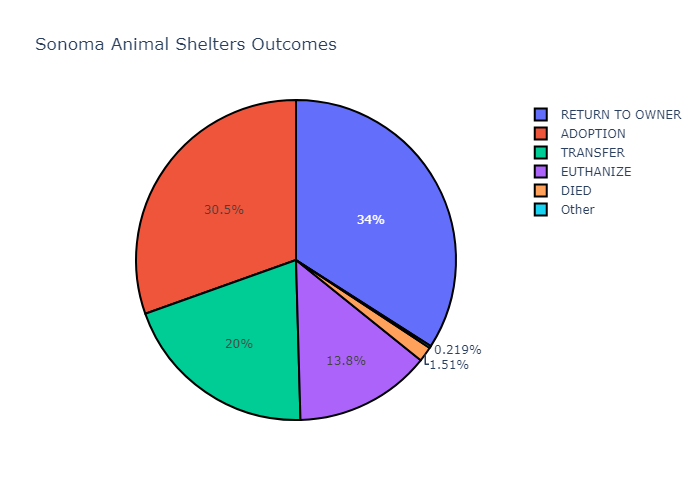

In [22]:
dist = data_sel['Outcome Type'].value_counts()
trace = go.Pie(values=(np.array(dist)), labels=dist.index)
layout = go.Layout(title='Sonoma Animal Shelters Outcomes')
fig = go.Figure(trace, layout)
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
# If you are running the notebook uncomment the line below to get an interactive plot
#fig.show()
Image(filename='piePlot.png')

**CHANGE**
By the above analysis, we can infer that the data set has a large number of them belongs to -- after that -- and next --. Also, a very small percentage of them have been --.

### 3.2 Visualizing the Yearly Intake

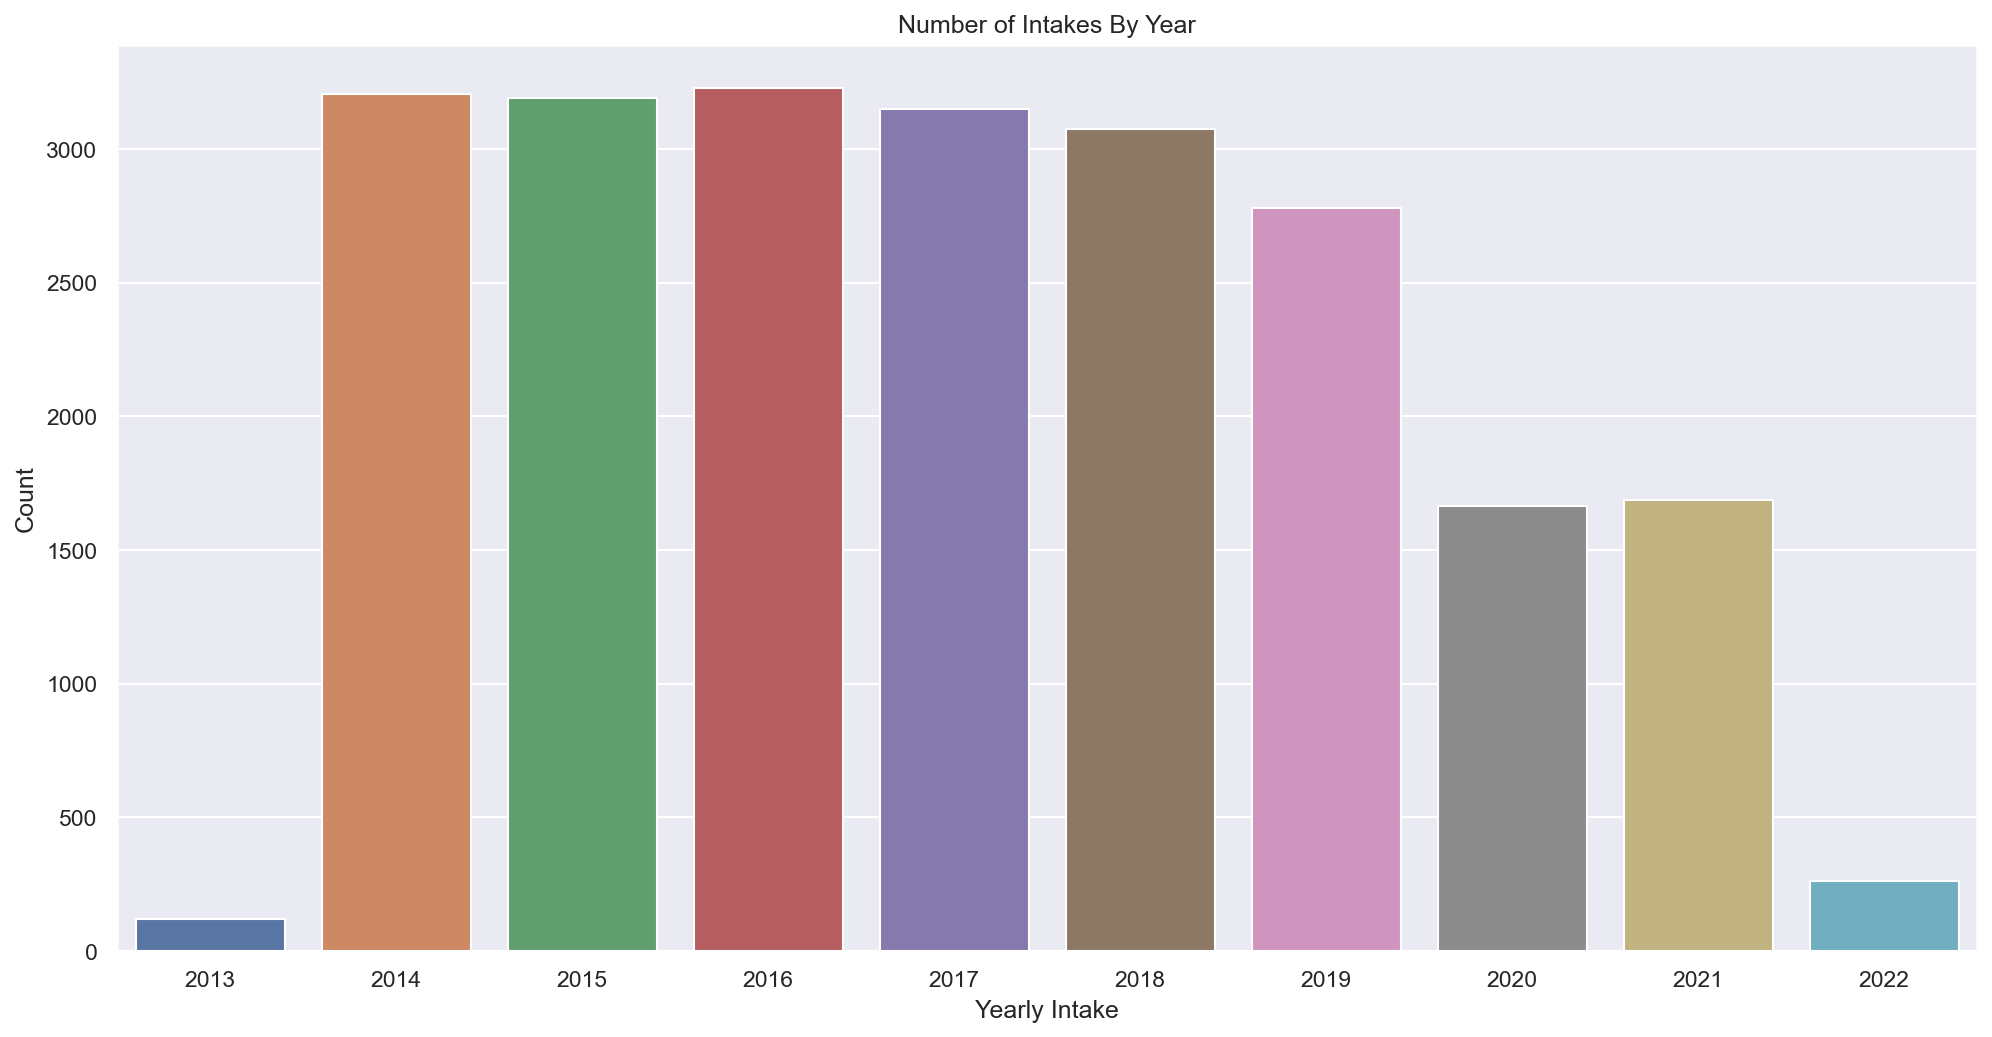

In [24]:
yearly_intake = data_sel.groupby([data_sel['Intake Date'].dt.year.rename('Year')])['Intake Date'].agg({'count'})
year_plot = sns.barplot(data=yearly_intake, x=yearly_intake.index, y='count')
year_plot.set(title='Number of Intakes By Year', xlabel='Yearly Intake', ylabel='Count');

**ADD COMMENTS**

### 3.3 Histogram Plot of Days in Shelter

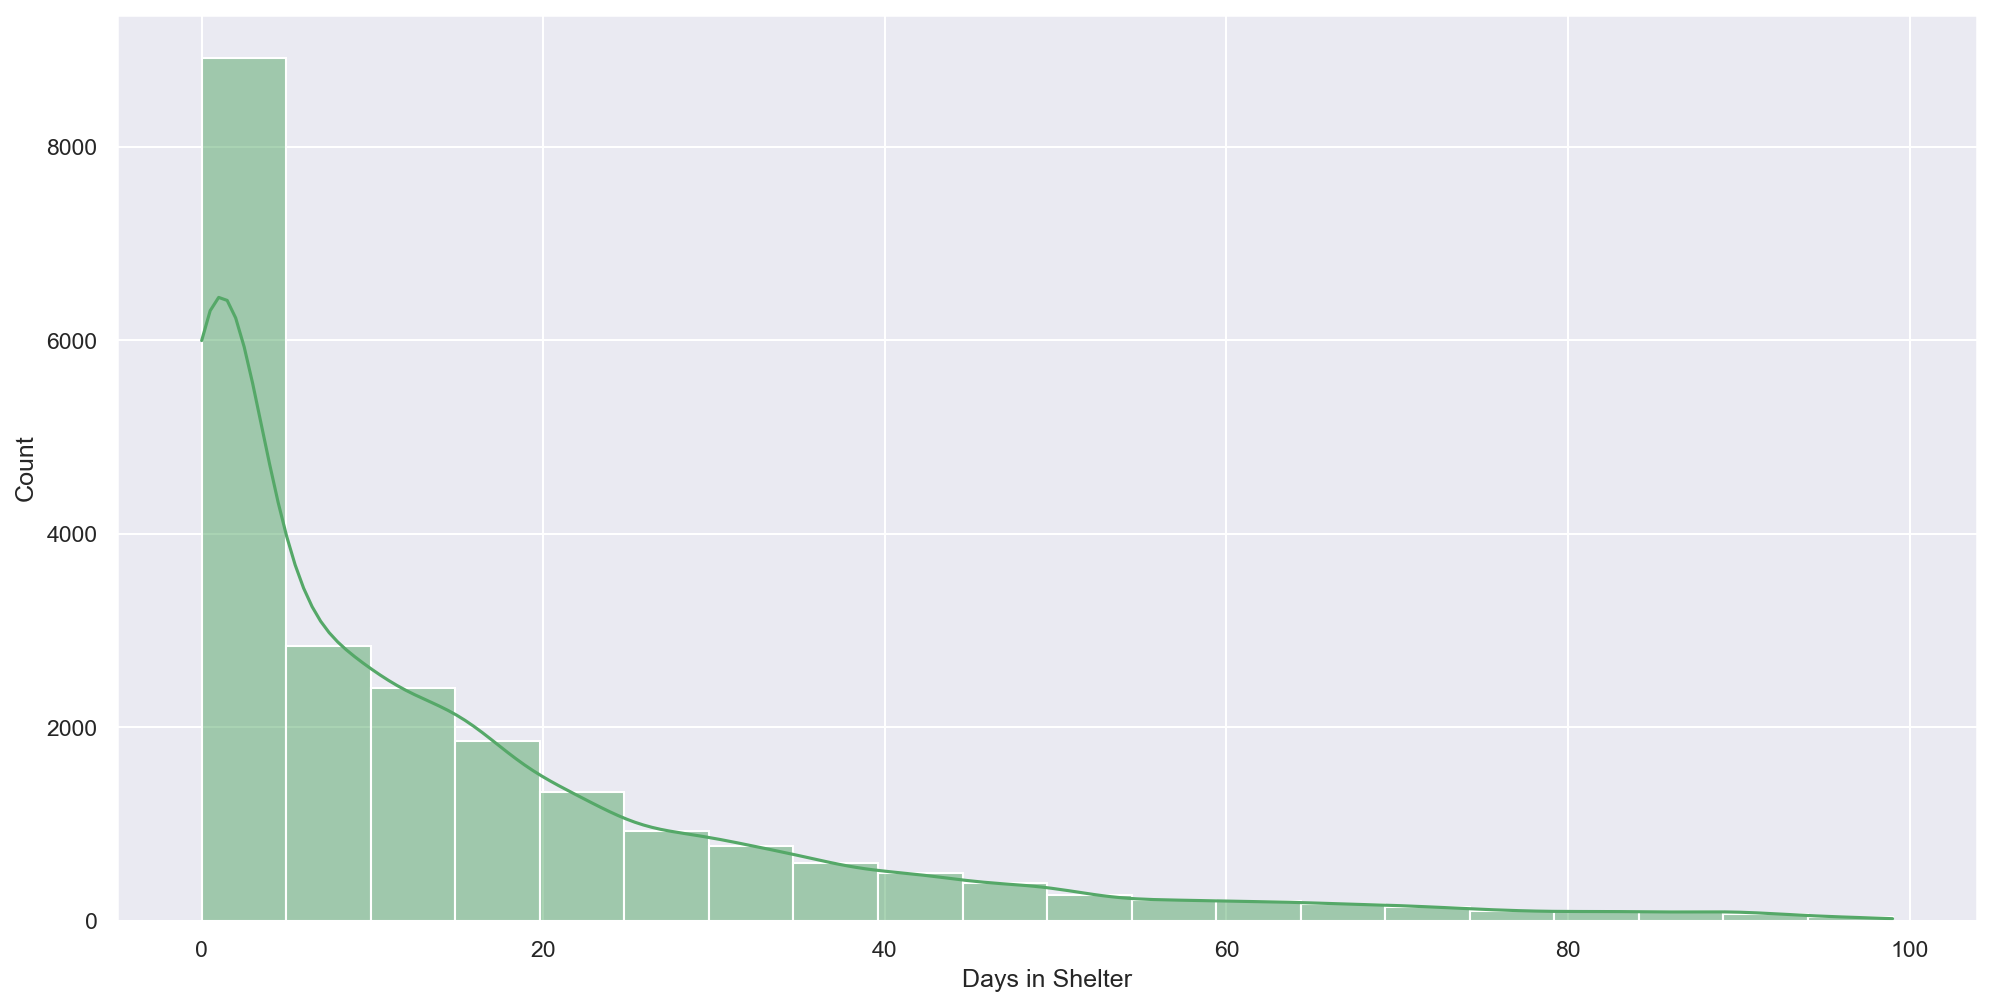

In [72]:
year_plot = sns.histplot(data_sel['Days in Shelter'][data_sel['Days in Shelter']<100], kde=True, color="g", bins=20)

### 3.4 Histogram Plots of Ages at Intake and Outcome (in Months and Years)

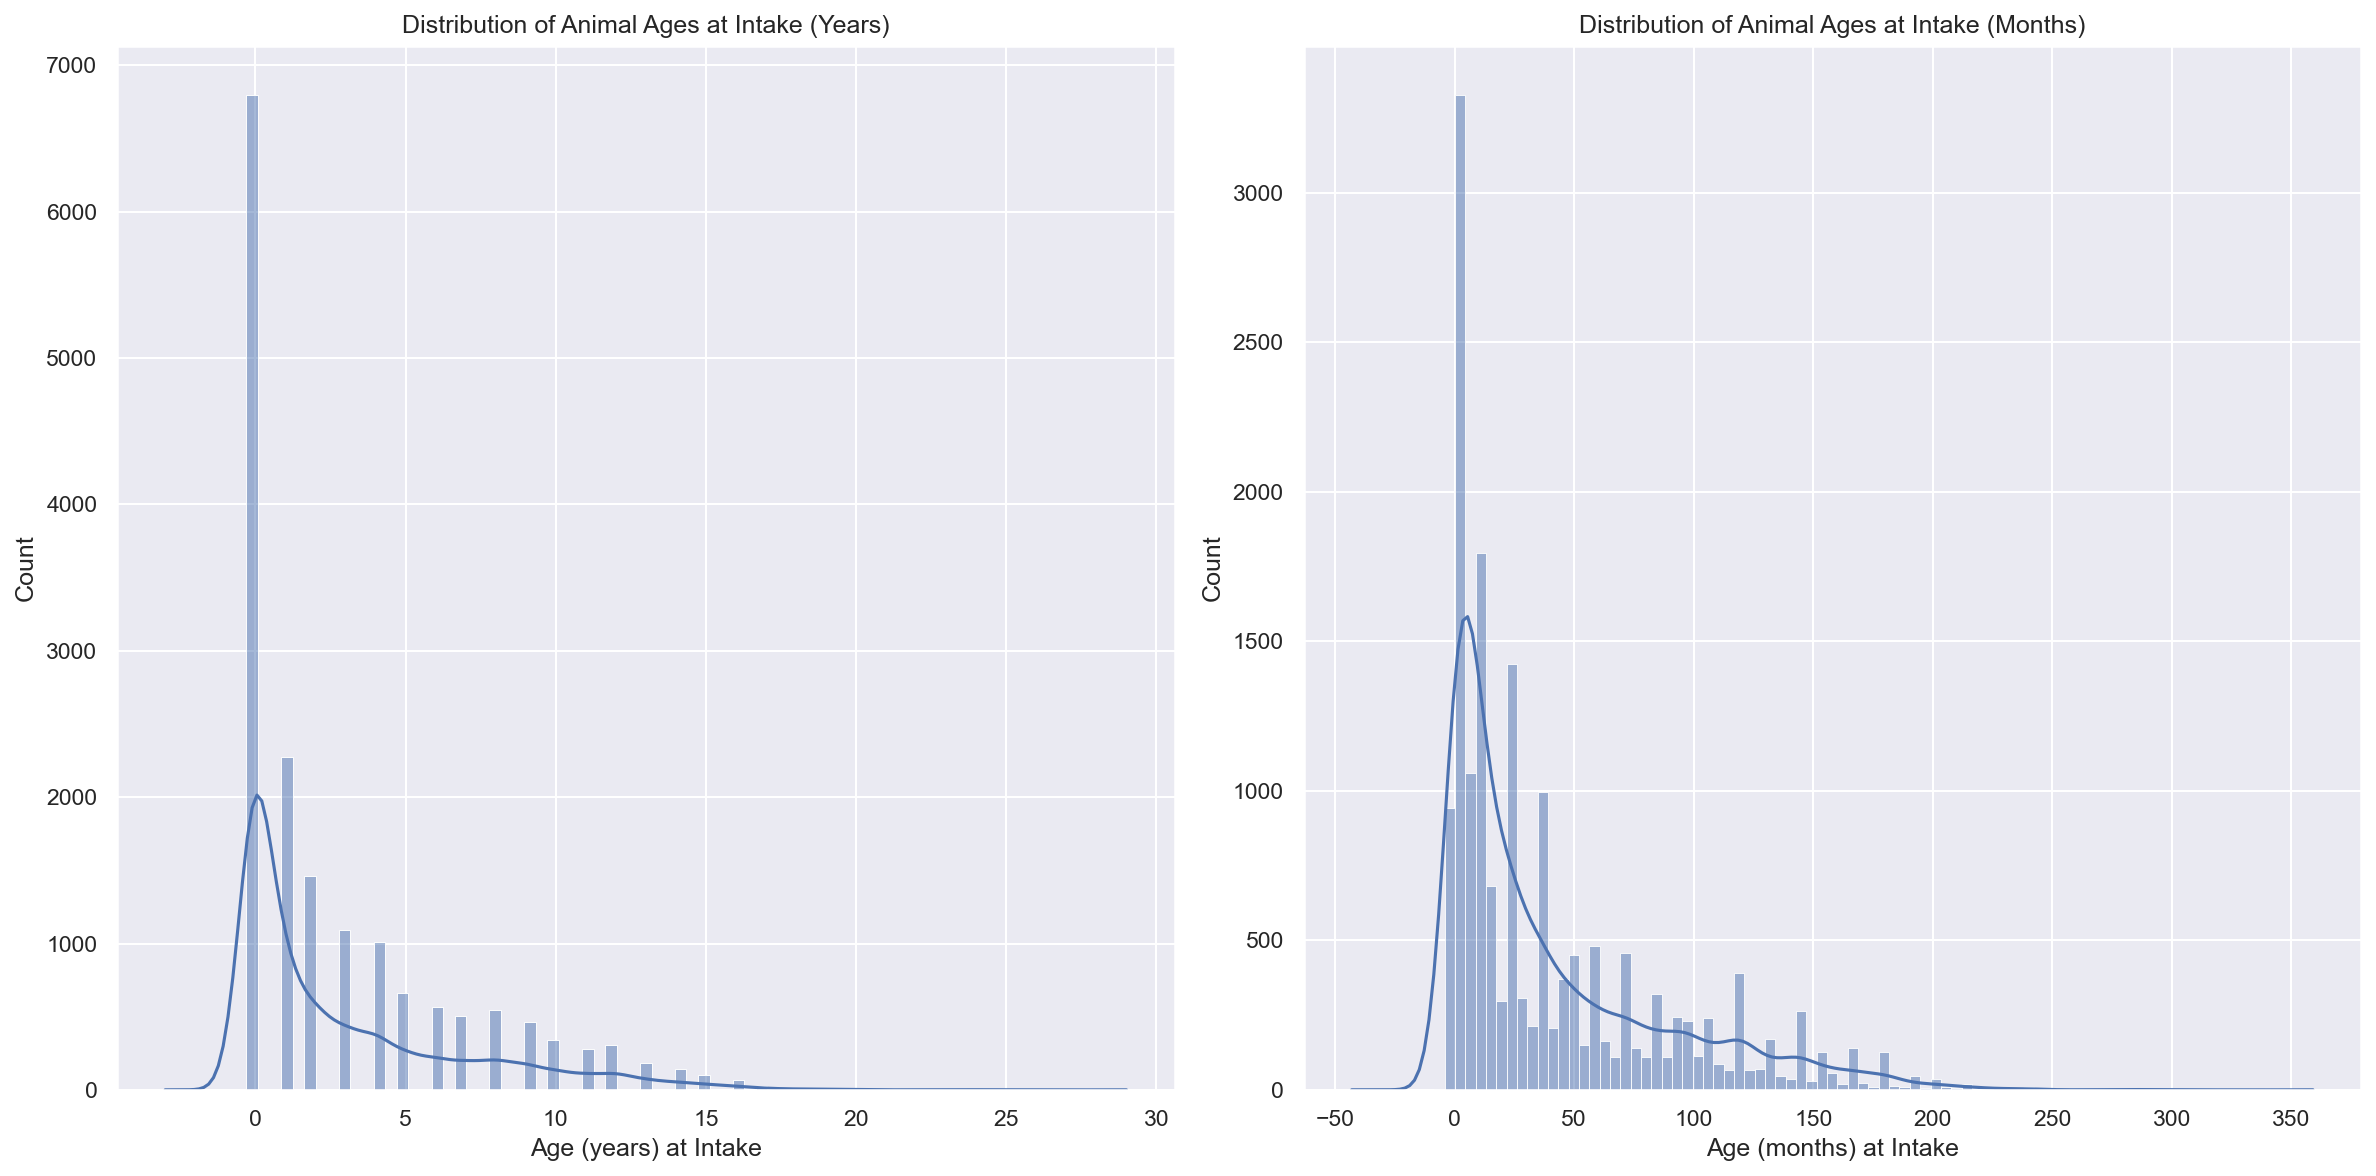

In [25]:
fig, axs = plt.subplots(ncols=2, nrows=1)
dist_plot = sns.histplot(data=data_sel.loc[data_sel['Age (years) at Intake'] != 999], x='Age (years) at Intake',
                         kde=True, ax=axs[0])
dist_plot.set(title="Distribution of Animal Ages at Intake (Years)")
dist_plot_2 = sns.histplot(data=data_sel.loc[data_sel['Age (months) at Intake'] != 999], x='Age (months) at Intake',
                           kde=True, ax=axs[1])
dist_plot_2.set(title="Distribution of Animal Ages at Intake (Months)")
fig.tight_layout()

**CHANGE**
Here we can see that the age distributions at intake/outcome are right skewed, meaning that most animals are admitted to the shelter while they are young, and they also leave the shelter (have an outcome) while they are young. The distributions are highly tailed and have many entries that correspond to old animals. We therefore decide to consider animals older than 17 years as outliers and remove them from our dataset.

In [26]:
#data_sel = data_sel.loc[data_sel['Age (years) at Intake'] <= 17]

### 3.5 Visualize Animal Types

DOG accounts for 56.55147749117082 % of the dataset
CAT accounts for 35.40614242925477 % of the dataset
OTHER accounts for 8.04238007957441 % of the dataset


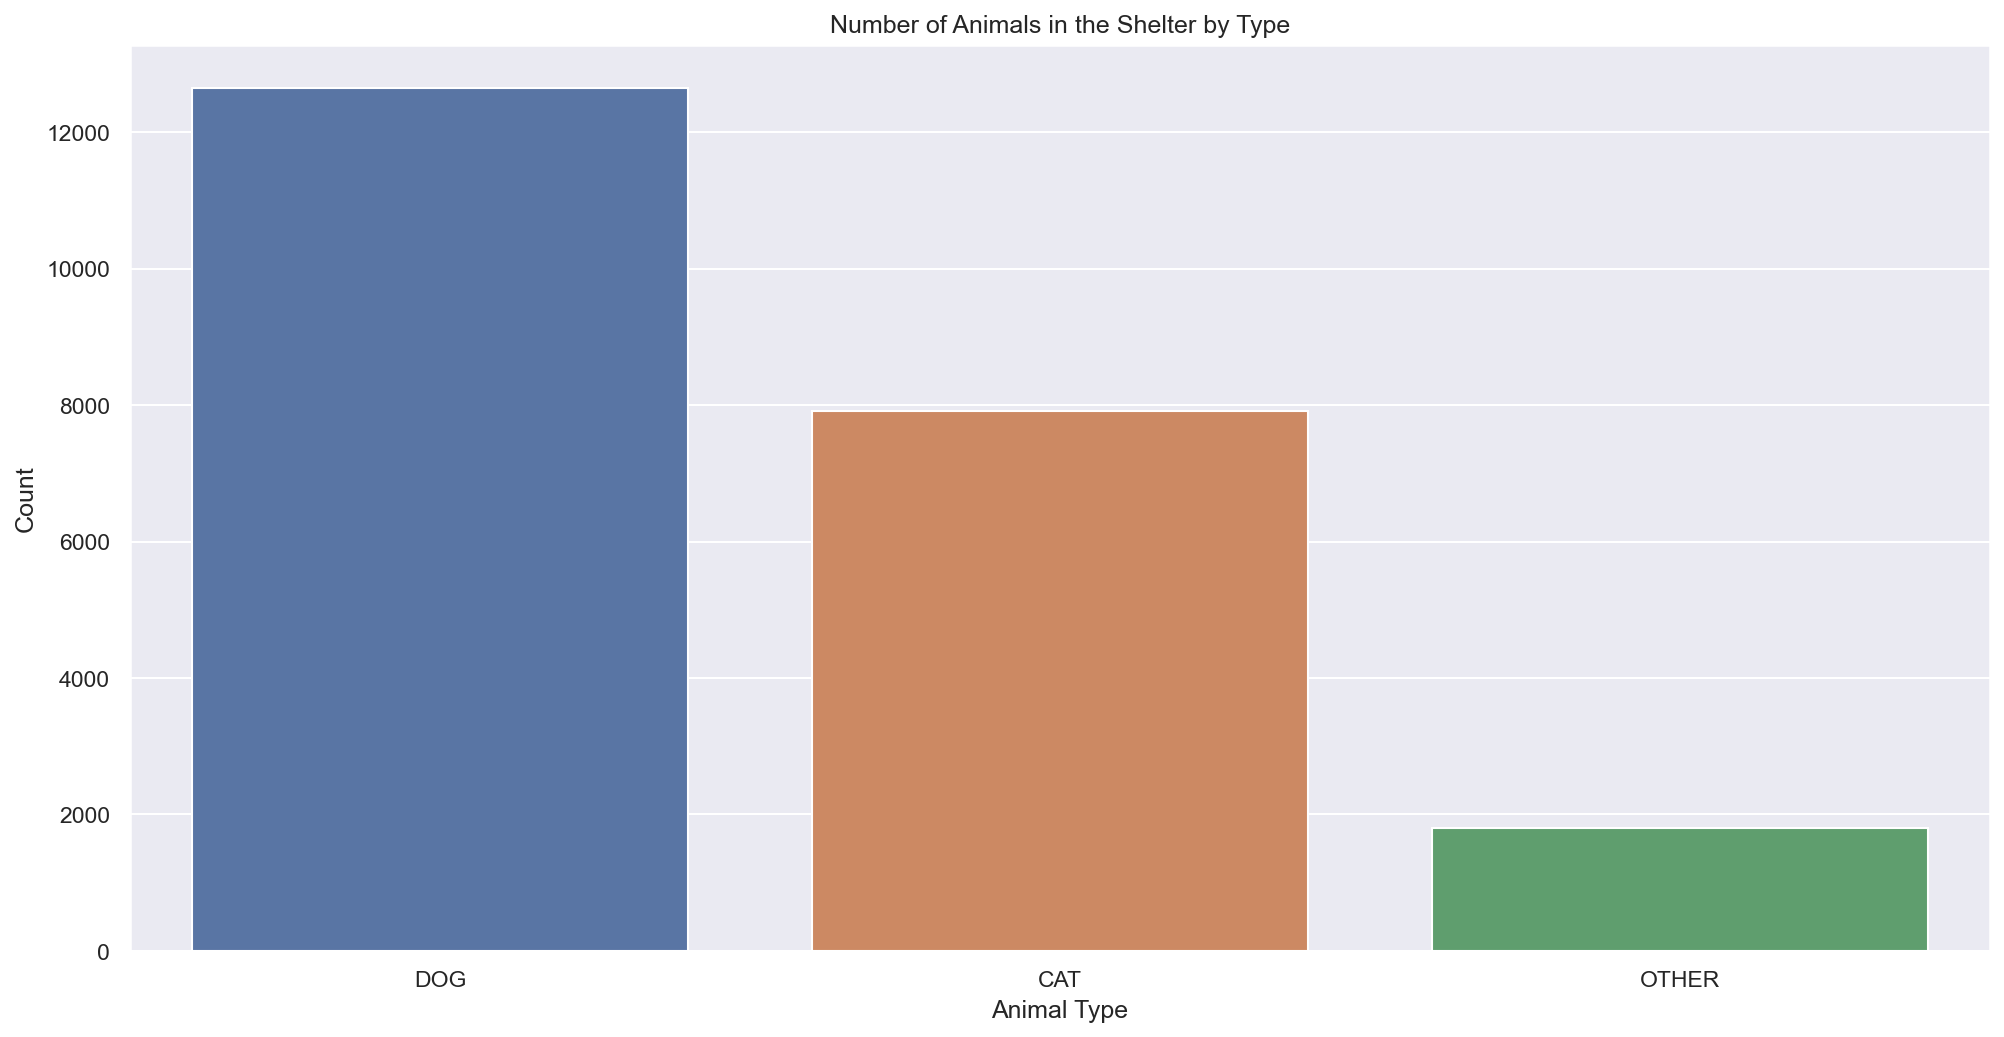

In [27]:
# Order of animal types to limit confusion. There is no reason for this particular order
type_order = ["DOG", "CAT", "OTHER"]

animal_type = data_sel['Type'].value_counts()
animal_type = pd.DataFrame(animal_type)

types_barplot = sns.barplot(data=animal_type, x=animal_type.index, y='Type', order=type_order)
types_barplot.set(title='Number of Animals in the Shelter by Type', xlabel='Animal Type', ylabel='Count')

for index, row in animal_type.iterrows():
    percentage = (row['Type'] / animal_type['Type'].sum()) * 100
    print(index, 'accounts for', percentage, '% of the dataset')

### 3.6 Analysing the Factors' Influence on the Outcome Type

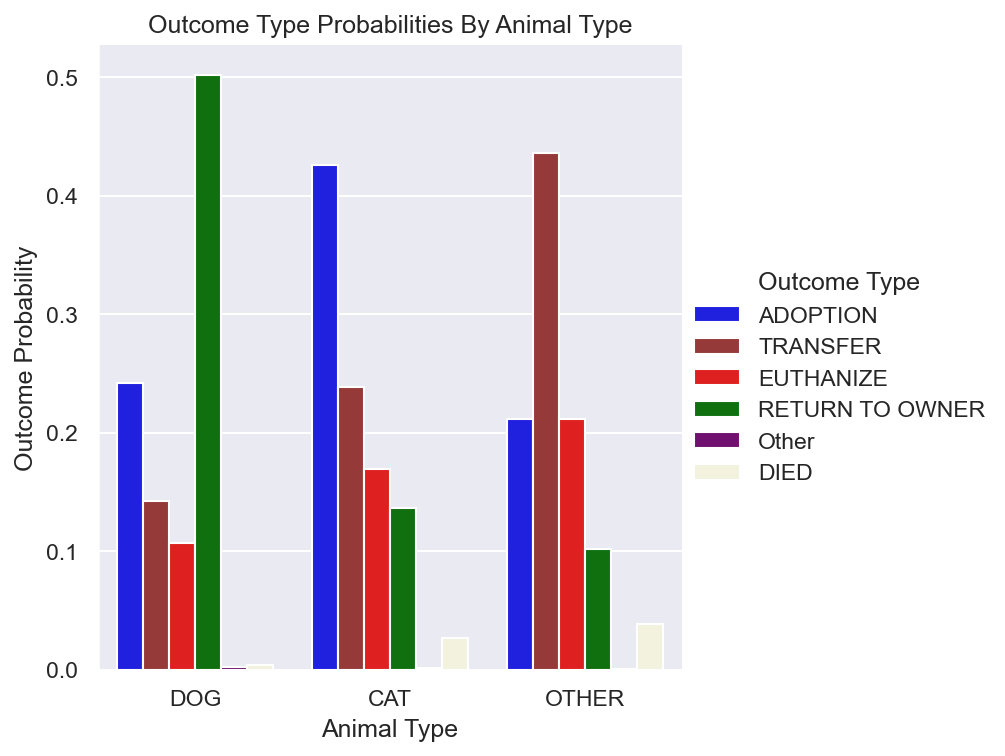

In [28]:
# Ensuring that all plots using outcome types will always have the same color for each outcome type.
# There is no specific reason for any of these colors, it was the originally generated set.
color_dict = {"ADOPTION": "blue",
              "TRANSFER": "brown",
              "EUTHANIZE": "red",
              "RETURN TO OWNER": "green",
              "Other": "purple",
              "DIED": "beige"}
color_order = color_dict.keys()
# Create a plot that shows how likely a certain type of animal is going to experience a certain outcome
prob_outcome_type = data_sel.groupby('Type')['Outcome Type'].value_counts(normalize=True).rename(
    'Outcome Probability').reset_index()
type_plot = sns.catplot(data=prob_outcome_type,
                        x='Type',
                        y='Outcome Probability',
                        order=type_order,
                        hue='Outcome Type',
                        hue_order=color_order,
                        palette=color_dict,
                        kind='bar')
type_plot.set(title='Outcome Type Probabilities By Animal Type', xlabel='Animal Type')
plt.show()

In the plot above, we can see that cats are much more likely to be adopted than any other species. However, dogs are much more likely to be returned to their owners. For all other animal types have a higher probability of being transferred to a different shelter, suggesting that some breeds may be quite exotic and therefore less likely to have a different outcome.

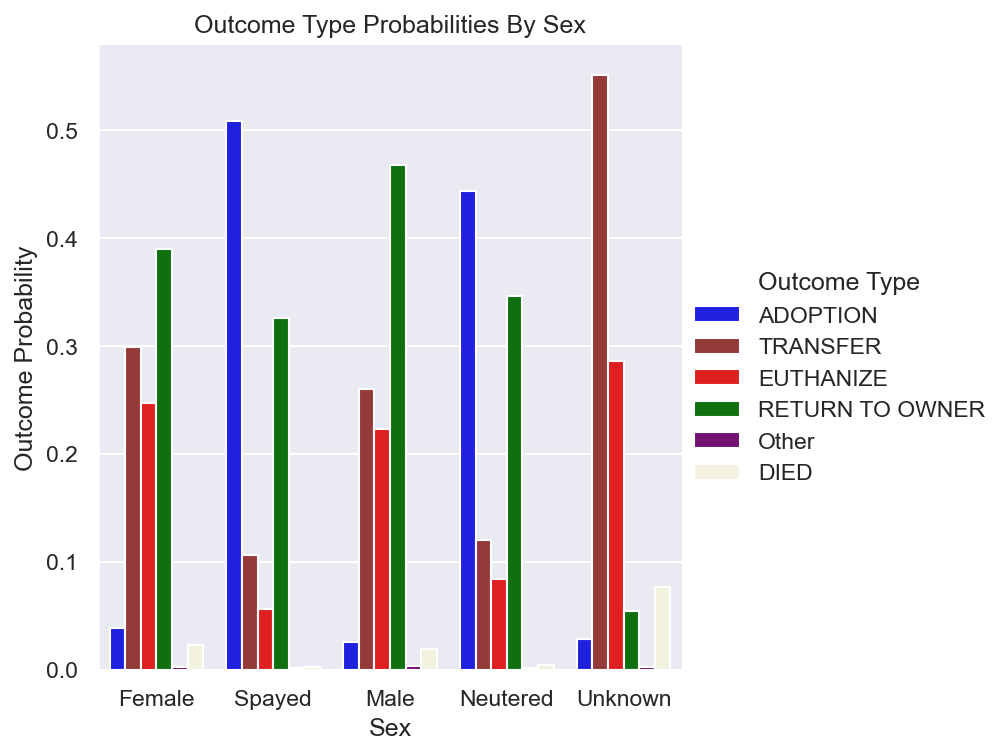

In [29]:
# Order of sex values to limit confusion
sex_order = ["Female", "Spayed", "Male", "Neutered", "Unknown"]
# Create a plot that shows how likely a certain type of animal (based on sex) is going to experience a certain outcome
prob_outcome_sex = data_sel.groupby('Sex')['Outcome Type'].value_counts(normalize=True).rename(
    'Outcome Probability').reset_index()
type_plot_sex = sns.catplot(data=prob_outcome_sex,
                            x='Sex',
                            y='Outcome Probability',
                            order=sex_order,
                            hue='Outcome Type',
                            hue_order=color_order,
                            palette=color_dict,
                            kind='bar')
type_plot_sex.set(title='Outcome Type Probabilities By Sex', xlabel='Sex')
plt.show()

In the figure above, we can see that pets that have been neutered/spayed are most likely to be adopted by new owners. Female/male pets are most likely to be returned to their owners and the 'Unknown' category is most likely to be passed on to another shelter.

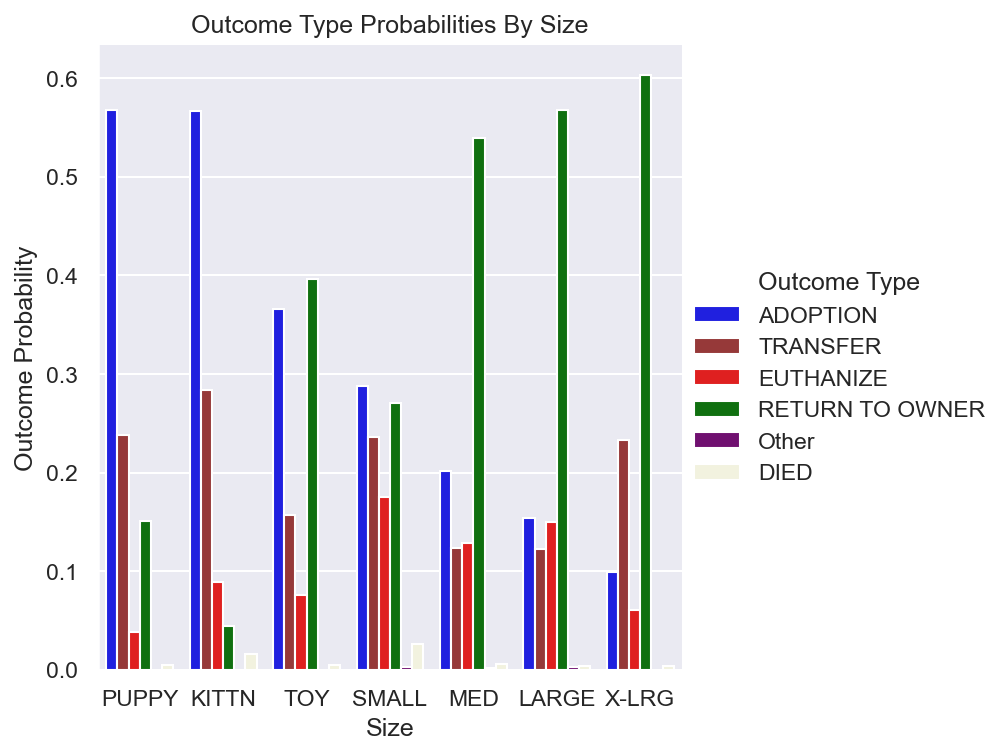

In [30]:
# Order of sex to limit confusion
size_order = ["PUPPY", "KITTN", "TOY", "SMALL", "MED", "LARGE", "X-LRG"]
# Create a plot that shows how likely a certain type of animal (based on sex) is going to experience a certain outcome
prob_outcome_size = data_sel.groupby('Size')['Outcome Type'].value_counts(normalize=True).rename(
    'Outcome Probability').reset_index()
type_plot_size = sns.catplot(data=prob_outcome_size,
                             x='Size',
                             y='Outcome Probability',
                             order=size_order,
                             hue='Outcome Type',
                             hue_order=color_order,
                             palette=color_dict,
                             kind='bar')
type_plot_size.set(title='Outcome Type Probabilities By Size', xlabel='Size')
plt.show()

**CHANGE**
Plot explanation goes here

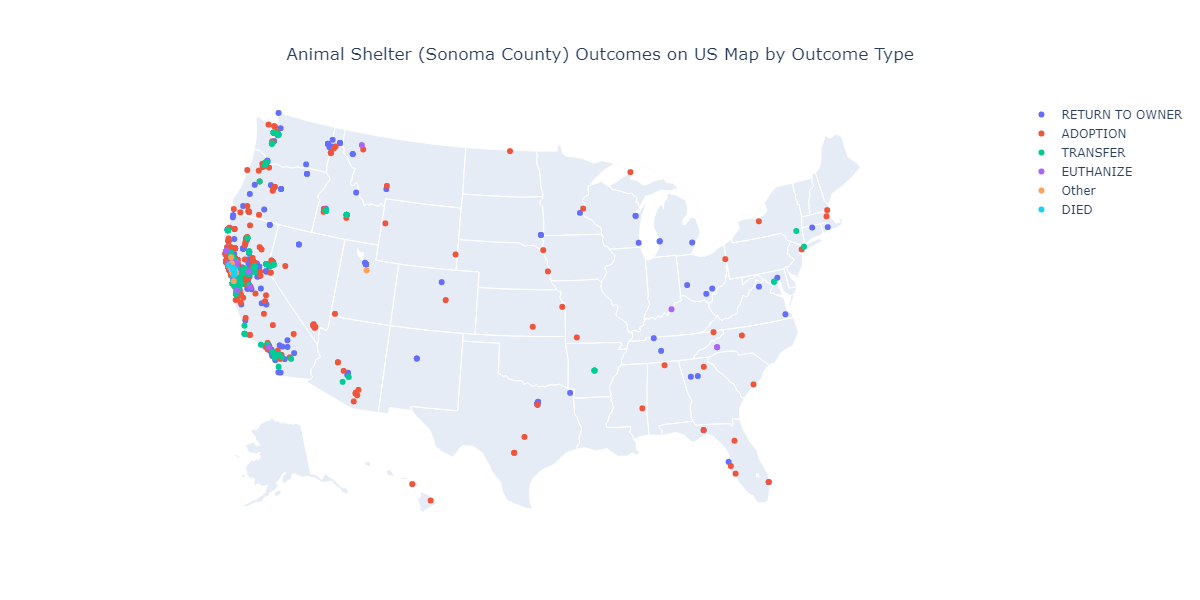

In [31]:
# Split the location column into latitude and longitude so that we can plot on a map
data_sel[['Lat', 'Long']] = data_sel['Location'].str.split(', ', n=1, expand=True)
data_sel['Lat'] = data_sel['Lat'].str[6:]
data_sel['Long'] = data_sel['Long'].str[:-1]

data_sel["Outcome_Cat"] = data_sel["Outcome Type"].astype('category').cat.codes

fig = go.Figure()
for outcome_type in list(data_sel['Outcome Type'].unique()):
    fig.add_trace(go.Scattergeo(
        lat=data_sel[data_sel['Outcome Type'] == outcome_type]['Lat'],
        lon=data_sel[data_sel['Outcome Type'] == outcome_type]['Long'],
        name=str(outcome_type))
    )

fig.update_layout(
    width=1200, height=600,
    title={
        'text': 'Animal Shelter (Sonoma County) Outcomes on US Map by Outcome Type',
        # Position of the title in the image
        'y': 0.92,
        'x': 0.5},
    geo_scope='usa',
)

# If you are running the notebook uncomment the line below to get an interactive plot
#fig.show()
Image(filename='mapPlot.png')

**CHANGE**
Add comments on map plot here!

## 4. Outcome Type Classification Modeling

### 4.1 Label Enconding + Train/Test Split

In [32]:
from sklearn.preprocessing import LabelEncoder

# Drop the columns that we won't be using
data_classifier = data_sel.drop(
    ['Days in Shelter', 'Outcome_Cat', 'Location', 'Name', 'Date Of Birth', 'Outcome Date', 'Lat', 'Long', 'Age (years) at Intake', 'Intake Date'], axis=1)

# Label Encoding of the columns using the sklearn LabelEncoder
for f in data_classifier.columns:
    if data_classifier[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(data_classifier[f].values))
        data_classifier[f] = lbl.transform(list(data_classifier[f].values))

In [33]:
# Split into features and labels
X = data_classifier.drop(['Outcome Type'], axis=1)
y = data_classifier['Outcome Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7441, test_size=0.2)

### 4.2 GridSearchCV to find best hyper-parameters of Random Forest

In [83]:
rfc=RandomForestClassifier(random_state=7441, bootstrap=True)

params = {'n_estimators': [70],
          'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth' : [6,7,8],
          'criterion' :['gini', 'entropy']}

cvgs_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv=5)
cvgs_rfc.fit(X_train, y_train)
best_params = cvgs_rfc.best_params_
score = cvgs_rfc.best_score_
print('Accuracy:', score * 100)
print(best_params)

Accuracy: 77.51327186364907
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 70}


### 4.3 Model Performance Analysis

In [85]:
rfc1=RandomForestClassifier(random_state=7441, bootstrap=True, criterion= 'entropy', max_depth= 8, max_features= 'auto', n_estimators= 70)
rfc1.fit(X_train, y_train)
y_pred_train = rfc1.predict(X_train)
y_pred_test = rfc1.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test))
print('Accuracy on training set:', metrics.accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy on test set:', metrics.accuracy_score(y_test, y_pred_test) * 100)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1343
           1       1.00      0.02      0.03        66
           2       0.92      0.68      0.78       608
           3       0.00      0.00      0.00         8
           4       0.81      0.87      0.84      1570
           5       0.66      0.62      0.64       879

    accuracy                           0.78      4474
   macro avg       0.69      0.51      0.52      4474
weighted avg       0.79      0.78      0.77      4474

Accuracy on training set: 78.05532271584241
Accuracy on test set: 78.05096110862763


C:\Users\K\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\K\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\K\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### 4.4 GridSearchCV to find best hyper-parameters of XGBoost

In [86]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False)

parameters = {'objective': ['multi:softmax'],
              'learning_rate': [0.08, 0.09, 0.10],
              'max_depth': [6, 7, 8],
              'n_estimators': [70],
              'eval_metric': ['mlogloss']}

cvgs_xgb = GridSearchCV(xgb_classifier, parameters, n_jobs=5, cv=StratifiedKFold(shuffle=True), scoring='accuracy')
cvgs_xgb.fit(X_train, y_train)
best_params = cvgs_xgb.best_params_
score = cvgs_xgb.best_score_
print('Accuracy:', score * 100)
print(best_params)

C:\Users\K\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Accuracy: 80.03352891869238
{'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 70, 'objective': 'multi:softmax'}


### 4.5 Model Performance Analysis

In [87]:
y_pred_train = cvgs_xgb.predict(X_train)
y_pred_test = cvgs_xgb.predict(X_test)
print(metrics.classification_report(y_test, y_pred_test))
print('Accuracy on training set:', metrics.accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy on test set:', metrics.accuracy_score(y_test, y_pred_test) * 100)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1343
           1       0.56      0.21      0.31        66
           2       0.84      0.76      0.80       608
           3       1.00      0.12      0.22         8
           4       0.85      0.88      0.86      1570
           5       0.73      0.63      0.68       879

    accuracy                           0.81      4474
   macro avg       0.79      0.58      0.62      4474
weighted avg       0.80      0.81      0.80      4474

Accuracy on training set: 85.81726739312657
Accuracy on test set: 80.50961108627627


### 4.6 Feature Importance

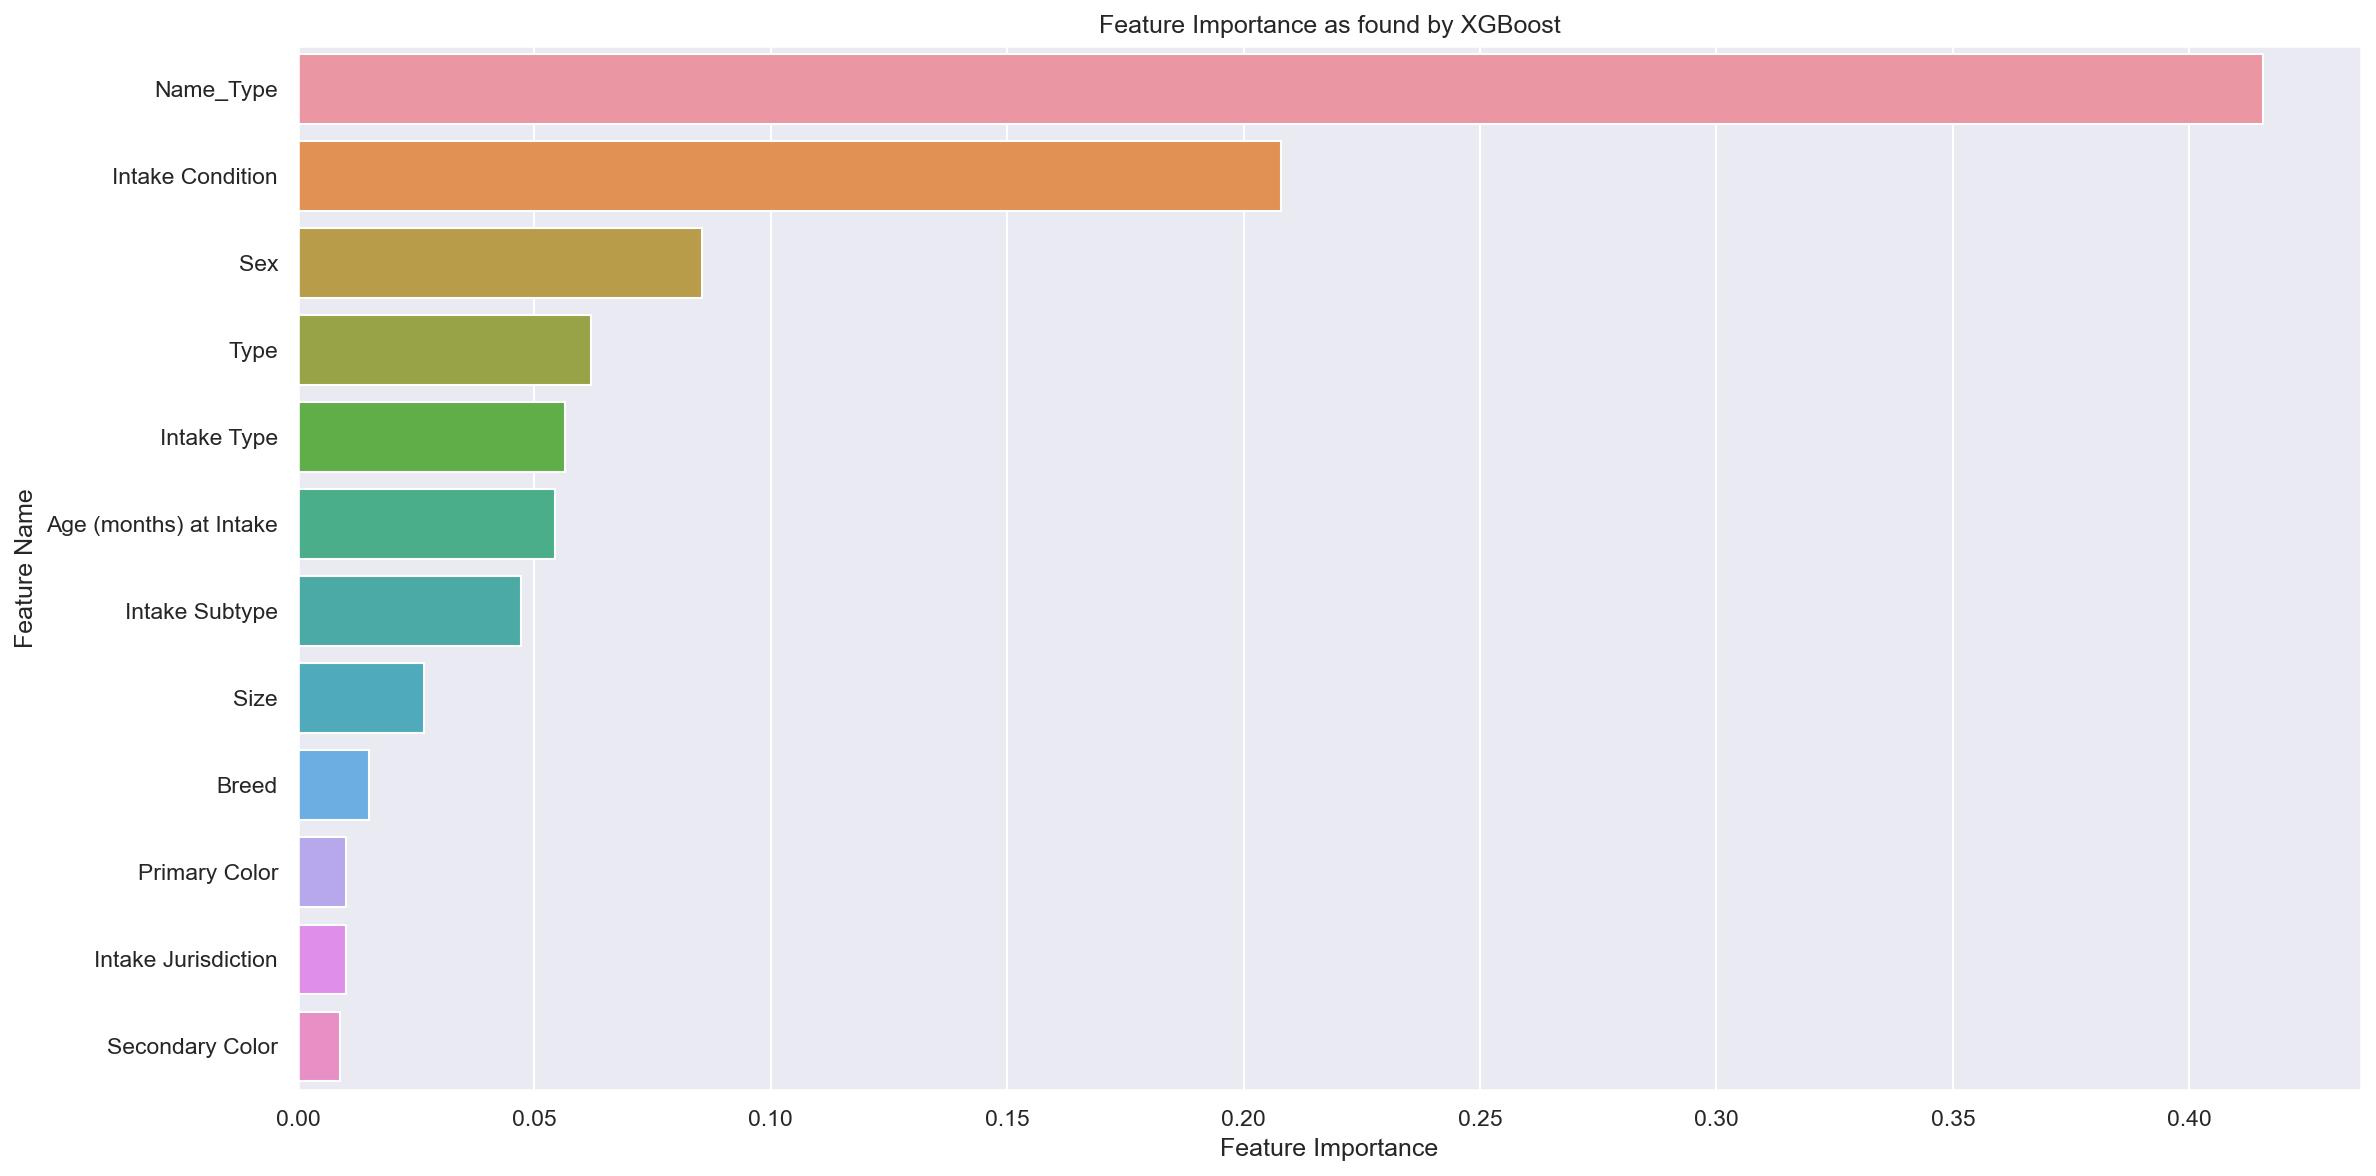

In [36]:
# Find the best features from XGBoost
best_features = clf.best_estimator_.feature_importances_
sort_by_index = best_features.argsort()[::-1]

# Plot the features by importance
features_plot = sns.barplot(x=best_features[sort_by_index], y=X_train.columns[sort_by_index])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance as found by XGBoost')
plt.tight_layout()
plt.show()